# Import Libraries

In [11]:
import os
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import gc
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from misl_dataset import train_valid_test_split

In [12]:
device = torch.device('cpu')
gc.collect()

0

Constants

In [13]:
epochs = 30
batch_size = 1
lr = 0.001
num_clusters = 10

# Model Definition

In [14]:
import torch.nn as nn
import torch

class DeepAttnMIL_Surv(nn.Module):
    """
    Deep AttnMISL Model definition
    """
    def __init__(self, cluster_num):
        super(DeepAttnMIL_Surv, self).__init__()
        self.embedding_net = nn.Sequential(nn.Conv1d(1000, 64, 1),
                                     nn.ReLU(),
                                     nn.AdaptiveAvgPool1d(1)
                                     )

        self.attention = nn.Sequential(
            nn.Linear(64, 32), # V
            nn.Tanh(),
            nn.Linear(32, 1)  # W
        )

        self.fc6 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32,2)
        )
        self.cluster_num = cluster_num

    def masked_softmax(self, x, mask=None):
        """
        Performs masked softmax, as simply masking post-softmax can be
        inaccurate
        :param x: [batch_size, num_items]
        :param mask: [batch_size, num_items]
        :return:
        """
        if mask is not None:
            mask = mask.float()
        if mask is not None:
            x_masked = x * mask + (1 - 1 / (mask+1e-5))
        else:
            x_masked = x
        x_max = x_masked.max(1)[0]
        x_exp = (x - x_max.unsqueeze(-1)).exp()
        if mask is not None:
            x_exp = x_exp * mask.float()
        return x_exp / x_exp.sum(1).unsqueeze(-1)

    def forward(self, x, mask):

        " x is a tensor list"
        res = []
        for i in range(self.cluster_num):
                
            hh = x[i]
            
            hh = hh.unsqueeze(0).reshape(1, 1000, len(hh))
            
            output = self.embedding_net(hh)
            
            output = output.view(output.size()[0], -1)
            
            res.append(output)

        h = torch.cat(res)

        b = h.size(0)
        c = h.size(1)

        h = h.view(b, c)
        
        A = self.attention(h)
        A = torch.transpose(A, 1, 0)  # KxN
        
        A = self.masked_softmax(A, mask)

        M = torch.mm(A, h)  # KxL

        Y_pred = self.fc6(M)

        return Y_pred

# Loading Dataset

In [15]:
# Kasra's use
data_path = './clustered_data.csv'
label_path = './BRCA_stages.csv'

# Raghul's use
# data_path = 'C:/Users/RaghulKrish/Desktop/UB/Spring_23/CVIP/Project/clustered_data.csv'
# label_path = 'C:/Users/RaghulKrish/Desktop/UB/Spring_23/CVIP/Project/BRCA_stages.csv'

train_data, valid_data, test_data = train_valid_test_split(data_path, label_path, 0.2, 0.2)

# train_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
# test_loader = DataLoader(test_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
# valid_loader = DataLoader(valid_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

['tcga-a1-a0sn' 'tcga-a1-a0sn' 'tcga-a1-a0sn' ... 'tcga-s3-aa17'
 'tcga-s3-aa17' 'tcga-s3-aa17']
['tcga-a1-a0sn' 'tcga-a2-a0t6' 'tcga-a2-a0ym' 'tcga-a7-a13d'
 'tcga-a7-a3rf' 'tcga-a8-a090' 'tcga-a8-a0ad' 'tcga-ac-a23e'
 'tcga-bh-a0bj' 'tcga-bh-a0hf' 'tcga-d8-a1ji' 'tcga-d8-a1xo'
 'tcga-e2-a15h' 'tcga-e9-a1r7' 'tcga-ew-a1ov' 'tcga-ol-a66o'
 'tcga-s3-aa17']
['tcga-a1-a0sf' 'tcga-a1-a0sf' 'tcga-a1-a0sf' ... 'tcga-ll-a6fp'
 'tcga-ll-a6fp' 'tcga-ll-a6fp']
['tcga-a1-a0sf' 'tcga-a7-a13e' 'tcga-ac-a23h' 'tcga-ac-a2b8'
 'tcga-bh-a0hl' 'tcga-bh-a1f5' 'tcga-bh-a1fe' 'tcga-bh-a1fg'
 'tcga-bh-a8fz' 'tcga-e2-a159' 'tcga-e2-a15d' 'tcga-ew-a6sd'
 'tcga-ll-a5yl' 'tcga-ll-a6fp']


c:\Users\RaghulKrish\Desktop\UB\Spring_23\CVIP\Project\CSE573-Final-Project\misl_dataset.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.labels['stage'] = self.labels.stage.map(lambda x: one_hot_binary(x))


constants

In [16]:
model = DeepAttnMIL_Surv(cluster_num = num_clusters).to(device)
model.train()

train_loss = []
loss_valid = []
acc_val = []
acc_train = []
best_loss = float('inf')
patience = 7

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = 0.005, momentum = 0.9)

def predict(batch, label):
    patient, mask = batch
    for cluster_id in range(len(patient)):
        patient[cluster_id] = patient[cluster_id].to(device)
    mask = mask.to(device)
    label = label.to(device)

    output = model(patient, mask)
    label.unsqueeze_(0)
    loss = criterion(output, label)
    output = output.to("cpu")
    y_pred = np.argmax(np.array(output), axis = 1)
    label = label.to("cpu")
    label = np.argmax(label, axis = 1)
    acc = accuracy(y_pred, label) 
    return {'loss': loss, 'acc': acc}

def accuracy(y_pred, labels):
    return np.sum(y_pred == labels.numpy()) / labels.shape[0] * 100

for i in range(epochs):
    epoch_loss = []
    for batch_idx, (batch, label) in enumerate(train_data):
        patient, mask = batch
        for cluster_id in range(len(patient)):
            patient[cluster_id] = patient[cluster_id].to(device)
        label = label.to(device)
        mask = mask.to(device)

        output = model(patient, mask)
        # print(output.shape)
        # print(label.shape)
        label.unsqueeze_(0)
        loss = criterion(output, label)
        epoch_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = torch.stack(epoch_loss)
    epoch_loss = epoch_loss.to("cpu").detach().numpy().mean()
    # epoch_loss = epoch_loss
    train_loss.append(epoch_loss)

    if i % 10 == 0:
        print(f'Epoch: {i} ---> Epoch Loss: {epoch_loss}')

    with torch.no_grad():
        train_op = [predict(batch, label) for batch_idx, (batch, label) in enumerate(train_data)]
        train_acc = [x['acc'] for x in train_op]
        acc_train.append((np.array(train_acc)).mean())
        
        valid_op = [predict(batch, label) for batch_idx, (batch, label) in enumerate(valid_data)]
        batch_losses = [x['loss'] for x in valid_op]
        valid_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['acc'] for x in valid_op]
        valid_acc = (np.array(batch_accs)).mean()
        acc_val.append(valid_acc)
        loss_valid.append(valid_loss)
        if i % 10 == 0:
            print(f"epoch: {i}, Validation loss: {valid_loss}, Validation Accuracy: {valid_acc}%")
    
    # Performing Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = model.state_dict()
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Validation loss hasn't improved in {patience} epochs. Stopping early!!!")
            break

Epoch: 0 ---> Epoch Loss: 0.6647961735725403
epoch: 0, Validation loss: 0.5427266955375671, Validation Accuracy: 85.71428571428571%
Epoch: 10 ---> Epoch Loss: 0.3788338303565979
epoch: 10, Validation loss: 0.7082076668739319, Validation Accuracy: 85.71428571428571%
Validation loss hasn't improved in 7 epochs. Stopping early!!!


In [17]:

# create a new instance of your model
model_test = DeepAttnMIL_Surv(num_clusters).to(device)

# load the best_model weights into the new instance
model_test.load_state_dict(best_model)

# set the model to evaluation mode
model_test.eval()

def test_predict(batch, label):
    patient, mask = batch
    for cluster_id in range(len(patient)):
        patient[cluster_id] = patient[cluster_id].to(device)
    mask = mask.to(device)
    label = label.to(device)

    output = model_test(patient, mask)
    label.unsqueeze_(0)
    loss = criterion(output, label)
    output = output.to("cpu")
    y_pred = np.argmax(np.array(output), axis = 1)
    label = label.to("cpu")
    label = np.argmax(label, axis = 1)
    acc = accuracy(y_pred, label) 
    return {'loss': loss, 'acc': acc, 'pred': y_pred, 'true': label}

with torch.no_grad():
    test_op = [test_predict(batch, label) for batch_idx, (batch, label) in enumerate(test_data)]
    batch_losses = [x['loss'] for x in test_op]
    test_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in test_op]
    test_acc = (np.array(batch_accs)).mean()

print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.44173958897590637, Test Accuracy: 88.23529411764706


Plotting Loss

Text(0, 0.5, 'Loss')

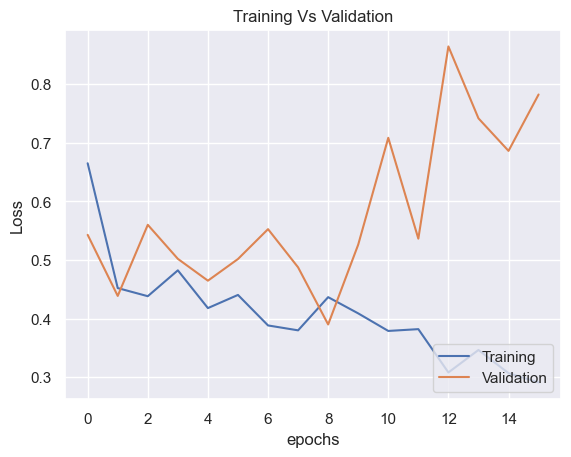

In [18]:
sns.set(style = "darkgrid") # Background Theme
# train_loss = torch.stack(train_loss)
plt.plot(train_loss)
loss_valid = torch.stack(loss_valid)
loss_valid = loss_valid.to('cpu')
plt.plot(loss_valid)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.xlabel("epochs")
plt.title("Training Vs Validation")
plt.ylabel("Loss")

Plotting Accuracy

Text(0, 0.5, 'Accuracy')

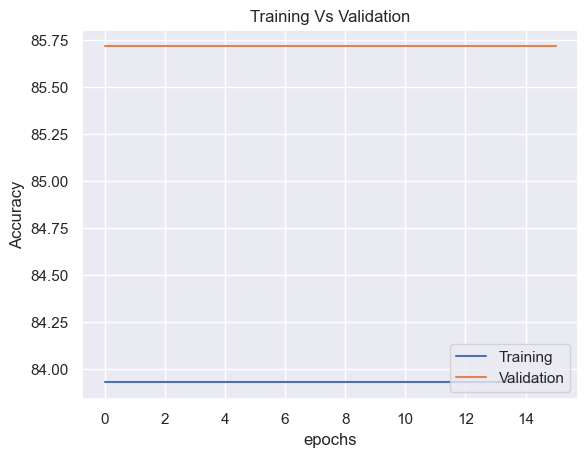

In [44]:
plt.plot(acc_train)
plt.plot(acc_val)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.xlabel("epochs")
plt.title("Training Vs Validation")
plt.ylabel("Accuracy")

Confusion Matrix

In [43]:
pred = np.array([x['pred'] for x in test_op])
true = np.stack([x['true'] for x in test_op])

pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

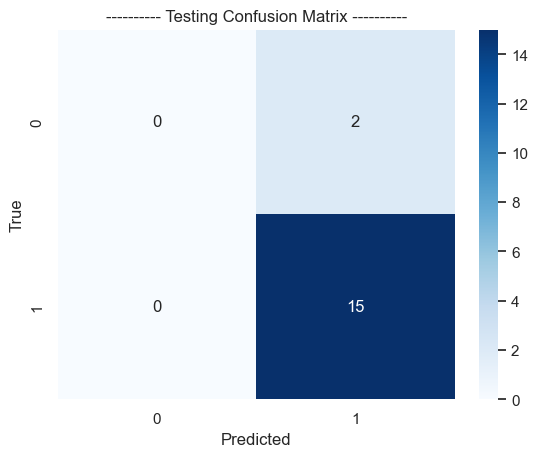

In [42]:
cm = confusion_matrix(true, pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("---------- Testing Confusion Matrix ----------")
plt.show()